In [1]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as TR
import pytorch_lightning as pl
from src.config import get_parser
from src.utilities.util import (
    grid_to_list,
    list_to_grid,
    make_faces,
)
from src.utilities.alignment import align
from src.utilities.vertex_normals import VertexNormals
from src.render.mesh_points_renderer import MeshPointsRenderer
from types import SimpleNamespace
from src.models.normal_generator import Generator


torch.set_printoptions(precision=4, sci_mode=False)

def normalize(t):
    return TR.Normalize(t.mean(), t.std())(t)

In [2]:
device = torch.device('cuda')

d = torch.load('./data/npz/ada_wong_resident_evil_256.pth')
vertices = d['vertices'][None].to(device)
normals = d['normals'][None].to(device)

sz = 32
sh = 90
sv = 64
vertices = vertices[:, :, sv:sv+sz, sh:sh+sz]
normals = normals[:, :, sv:sv+sz, sh:sh+sz]

vertices = F.interpolate(vertices, scale_factor=16)
normals =  F.interpolate(normals, scale_factor=16)
normals = F.normalize(normals, dim=1)
colors = torch.ones_like(vertices)
print(vertices.shape, normals.shape, colors.shape)

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


torch.Size([1, 3, 224, 224])


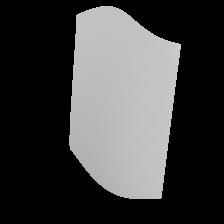

In [3]:
def get_aligned(vrt, nrm):
    p_v, p_n =  align(grid_to_list(vrt), 
                      grid_to_list(nrm),
                      rotate=False)
    return list_to_grid(p_v), list_to_grid(p_n)
    
#224x224
config = get_parser().parse_args(args=[])
config.fast_image_size = 224
config.fast_baseline_size = vertices.size(-1)
config.viewpoint_distance = 0.8

config.fast_image_size = 224
config.fast_baseline_size = vertices.size(-1)
config.viewpoint_distance = 1.0

R = MeshPointsRenderer(config).to(device)
R

vrt_a, _ = get_aligned(vertices, normals)

renders = R(vrt_a, colors, grayscale=False)
rndr_mean, rndr_std =  renders.mean(),  renders.std()
print(renders.shape)
TR.ToPILImage()(renders[0])

In [4]:
vrt_nrm = VertexNormals(config, size=vertices.size(-1)).to(device)

def calculate_normals(t):
    nrm = vrt_nrm.vertex_normals_fast(grid_to_list(t))
    return list_to_grid(nrm)

In [5]:
sn = SimpleNamespace(fast_generator_channels=[ 128, 128, 128, 128])

G = Generator(sn).to(device)

optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

In [6]:
#img_f = '/home/bobi/Desktop/pic2mesh/data/textures/mouth.jpg'
img_f = '/home/bobi/Desktop/pic2mesh/data/textures/Zbrush-Details.jpg'

img = Image.open(img_f)
img_size = 224
transform = TR.Compose([
    TR.Resize([img_size, img_size]),
    #Grayscale(),
    TR.ToTensor(),
    #Normalize(mean=(mean), std=(std)),
])
style_img_t = transform(img)
img_mean = style_img_t.reshape(3, -1).mean(dim=1)
img_std = style_img_t.reshape(3, -1).std(dim=1)
print(img_mean, img_std)
transform = TR.Compose([
    TR.Resize([img_size, img_size]),    
    TR.ToTensor(),
    TR.Normalize(mean=img_mean, std=img_std),
])
style_img_t = transform(img)[None].to(device)
style_img_t.shape

tensor([0.4308, 0.4252, 0.4113]) tensor([0.1197, 0.1178, 0.1165])


torch.Size([1, 3, 224, 224])

In [7]:
def gram_matrix(t):
    a, b, c, d = t.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = t.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

gram_matrix(style_img_t)

tensor([[0.3333, 0.3332, 0.3332],
        [0.3332, 0.3333, 0.3332],
        [0.3332, 0.3332, 0.3333]], device='cuda:0')

In [8]:
from torchvision import models

#[0,5,10,19,28] are the index of the layers we will be using to calculate the loss as per the paper of NST
#Defining a class that for the model
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        #Here we will use the following layers and make an array of their indices
        # 0: block1_conv1
        # 5: block2_conv1
        # 10: block3_conv1
        # 19: block4_conv1
        # 28: block5_conv1
        self.req_features= [
            #'0',
            '5',
            '10',
            '19',
            #'28'
        ] 
        #Since we need only the 5 layers in the model so we will be dropping all the rest layers from the features of the model
        self.model=models.vgg19(pretrained=True).features[:29] #model will contain the first 29 layers
    
   
    #x holds the input tensor(image) that will be feeded to each layer
    def forward(self,x):
        #initialize an array that wil hold the activations from the chosen layers
        features=[]
        #Iterate over all the layers of the mode
        for layer_num,layer in enumerate(self.model):
            #activation of the layer will stored in x
            x=layer(x)
            #appending the activation of the selected layers and return the feature array
            if (str(layer_num) in self.req_features):
                features.append(x)
                
        return features
    
model =  VGG().to(device).eval() 
model

VGG(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [9]:
bs = 1
style_img_t = style_img_t.expand(bs, -1, -1, -1)
style_img_t.shape

torch.Size([1, 3, 224, 224])

In [10]:
def all_gram_matrices(features):
    return [gram_matrix(f) for f in features]

def calc_style_loss(gen_features, orig_gms):
    gen_gms = all_gram_matrices(gen_features)    
    return sum([
       torch.mean((G-A)**2)
       for (G, A) in
       zip(gen_gms, orig_gms)
    ])

orig_features =  model(style_img_t)
orig_gms = all_gram_matrices(orig_features)
orig_gms = [f.detach() for f in orig_gms]
len(orig_gms), len(orig_features)

(3, 3)

In [11]:
steps = 1001

vert = vertices.clone()

for step in range(steps):
    optimizer.zero_grad()
    
    vertices_exp = vertices.expand(bs, -1, -1, -1)
    vert = vertices_exp.clone()
    vert += torch.randn_like(vert) * 0.0002
    normals = calculate_normals(vert)
    vert, colors = G(vert, normals)
    normals  = calculate_normals(vert.detach())
    
    vrt_a, nrm_a = get_aligned(vert, normals)
    renders = R(vrt_a, colors, grayscale=False)
    
    renders = normalize(renders)
    
    gen_features = model(renders)
    style_loss = calc_style_loss(gen_features, orig_gms)
    diff_loss = F.mse_loss(vert, vertices_exp, reduction='sum' )
    loss = style_loss * 10000 + diff_loss * 0.1
    loss.backward()
    optimizer.step()
    
    p = 0.05
    vert = vert.detach().mean(dim=0, keepdim=True)
    vertices = (1-p) * vertices+ (p* vert.detach())
    if step % 10 == 0:
        print(step, f"{style_loss.item():.9f}", f"{diff_loss.item():.9f}")
    if  step % 10 == 0: # step < 100 or 
        renders = R(vrt_a, colors, grayscale=False)
        img = TR.ToPILImage()(renders[0])
        img.save(f'./data/fit/5_{step}.png')
img.save(f'./data/fit/5_{steps}.png')

0 0.000071350 0.031473637
10 0.000059971 0.041955624
20 0.000056349 0.137909442
30 0.000057158 0.202379227
40 0.000056866 0.331571549
50 0.000057623 0.760842562
60 0.000059061 0.093008235
70 0.000057771 0.031847019
80 0.000058020 0.033376478
90 0.000057771 0.031498905
100 0.000057233 0.031791426
110 0.000059117 0.031756070
120 0.000056932 0.032664016
130 0.000057763 0.038236737
140 0.000056847 0.046444573
150 0.000057292 0.078013174
160 0.000057829 0.080911465
170 0.000056318 0.072313741
180 0.000059508 0.236562967
190 0.000064147 0.264522910
200 0.000061632 0.123133354
210 0.000055893 0.064897180
220 0.000058008 0.033878632
230 0.000057916 0.037398115
240 0.000060586 0.033362877
250 0.000057084 0.035077214
260 0.000057967 0.042399820
270 0.000057764 0.035176422
280 0.000057221 0.038449936
290 0.000059794 0.043243349
300 0.000057004 0.038780048
310 0.000056468 0.036560073
320 0.000057100 0.034269549
330 0.000055947 0.043129440
340 0.000057921 0.038498584
350 0.000057975 0.039371870
360